In [1]:
import numpy as np
import pulser
from pulser.devices import DigitalAnalogDevice
from pulser.register import Register
from pulser.pulse import Pulse
from pulser.waveforms import BlackmanWaveform

# Qubovert

In [2]:
from qubovert.problems import GraphPartitioning
from qubovert.utils import solve_qubo_bruteforce as qubo_solver

In [39]:
# edges = {("a", "b"), ("a", "c"), ("c", "d"),
edges = {("a", "b"), ("a", "c"), ("a", "d"), ("b", "c"), ("d", "e"), ("e", "f"), ("f", "d")}

In [40]:
problem = GraphPartitioning(edges) 

In [41]:
problem.degree

3

In [42]:
Q = problem.to_qubo()
Q.pretty_str()

'6.0 x(0) x(1) - 13.0 x(0) - 13.0 x(1) + 27.0 + 6.0 x(0) x(2) - 13.0 x(2) + 6.0 x(0) x(3) - 12.0 x(3) + 4.0 x(0) x(4) - 13.0 x(4) + 4.0 x(0) x(5) - 12.0 x(5) + 4.0 x(1) x(2) + 4.0 x(1) x(3) + 6.0 x(1) x(4) + 6.0 x(1) x(5) + 4.0 x(2) x(3) + 6.0 x(2) x(4) + 6.0 x(2) x(5) + 6.0 x(3) x(4) + 4.0 x(3) x(5) + 4.0 x(4) x(5)'

In [43]:
print(problem.to_quso().pretty_str())
print(problem.to_qubo().pretty_str())

1.5 z(0) z(1) + 1.5 z(0) z(2) + 1.5 z(0) z(3) + z(0) z(4) + z(0) z(5) + z(1) z(2) + z(1) z(3) + 1.5 z(1) z(4) + 1.5 z(1) z(5) + z(2) z(3) + 1.5 z(2) z(4) + 1.5 z(2) z(5) + 1.5 z(3) z(4) + 8.0 + z(3) z(5) + z(4) z(5)
6.0 x(0) x(1) - 13.0 x(0) - 13.0 x(1) + 27.0 + 6.0 x(0) x(2) - 13.0 x(2) + 6.0 x(0) x(3) - 12.0 x(3) + 4.0 x(0) x(4) - 13.0 x(4) + 4.0 x(0) x(5) - 12.0 x(5) + 4.0 x(1) x(2) + 4.0 x(1) x(3) + 6.0 x(1) x(4) + 6.0 x(1) x(5) + 4.0 x(2) x(3) + 6.0 x(2) x(4) + 6.0 x(2) x(5) + 6.0 x(3) x(4) + 4.0 x(3) x(5) + 4.0 x(4) x(5)


In [44]:
obj, sol = qubo_solver(Q)

In [45]:
sol # 0: a, 3: b, 1: c, 2: d

{0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0}

In [46]:
solution = problem.convert_solution(sol)
solution

({'a', 'b', 'c'}, {'d', 'e', 'f'})

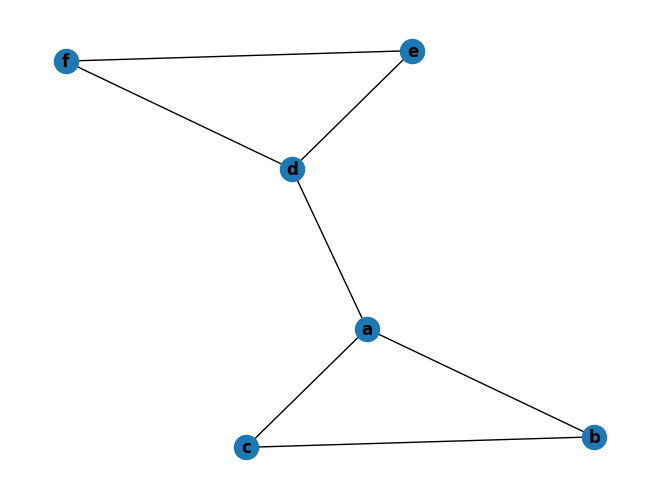

In [47]:
# draw the graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

# Solve with Pulser

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [49]:
problem.to_qubo().pretty_str()

'6.0 x(0) x(1) - 13.0 x(0) - 13.0 x(1) + 27.0 + 6.0 x(0) x(2) - 13.0 x(2) + 6.0 x(0) x(3) - 12.0 x(3) + 4.0 x(0) x(4) - 13.0 x(4) + 4.0 x(0) x(5) - 12.0 x(5) + 4.0 x(1) x(2) + 4.0 x(1) x(3) + 6.0 x(1) x(4) + 6.0 x(1) x(5) + 4.0 x(2) x(3) + 6.0 x(2) x(4) + 6.0 x(2) x(5) + 6.0 x(3) x(4) + 4.0 x(3) x(5) + 4.0 x(4) x(5)'

In [51]:
dict(problem.to_qubo())

{(0, 1): 6.0,
 (0,): -13.0,
 (1,): -13.0,
 (): 27.0,
 (0, 2): 6.0,
 (2,): -13.0,
 (0, 3): 6.0,
 (3,): -12.0,
 (0, 4): 4.0,
 (4,): -13.0,
 (0, 5): 4.0,
 (5,): -12.0,
 (1, 2): 4.0,
 (1, 3): 4.0,
 (1, 4): 6.0,
 (1, 5): 6.0,
 (2, 3): 4.0,
 (2, 4): 6.0,
 (2, 5): 6.0,
 (3, 4): 6.0,
 (3, 5): 4.0,
 (4, 5): 4.0}

In [ ]:
def problem_to_matrix(problem):
    n = len(problem.V)
    Q = np.zeros((n, n))
    qubo_dict = dict(problem.to_qubo())
    c = 0
    for ij, val in qubo_dict.items():
        if len(ij) == 0:
            c += val
        elif len(ij) == 2:
            i, j = ij
            Q[i, j] = val/2
            Q[j, i] = val/2
        elif len(ij) == 1:
            i = ij[0]
            Q[i, i] = val
        else:
            print(ij)
            raise ValueError("Invalid key in QUBO dictionary")
    return Q, c

In [73]:
Q, d = problem_to_matrix(problem)
print(Q)
print(d)

6
[[-13.   3.   3.   3.   2.   2.]
 [  3. -13.   2.   2.   3.   3.]
 [  3.   2. -13.   2.   3.   3.]
 [  3.   2.   2. -12.   3.   2.]
 [  2.   3.   3.   3. -13.   2.]
 [  2.   3.   3.   2.   2. -12.]]
27.0


In [79]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
sols = [s[0] for s in sort_zipped[:3]]
sort_zipped[:3]

[('011100', -26.0), ('100011', -26.0), ('000111', -23.0)]

In [80]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [86]:
costs = []
np.random.seed(6)
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q,),
    method="Nelder-Mead",
    # method="CG",
    # method="COBYQA",
    # method = "L-BFGS-B",
    # method = "Powell",
    # method = "trust-constr",
    tol=1e-6,
    options={"maxiter": 20000000, "maxfev": None},
    bounds = [(-40, 40) for _ in range(len(Q) * 2)]
)
coords = np.reshape(res.x, (len(Q), 2))

In [87]:
Q_new = squareform(
    DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6
)
Q_new
# note that Q_new is pretty far away in some indices from Q!

array([[0.        , 2.34559645, 0.04514518, 2.4211346 , 2.66809172,
        0.07642994],
       [2.34559645, 0.        , 0.12936179, 0.11021182, 3.31534694,
        2.42578787],
       [0.04514518, 0.12936179, 0.        , 0.13661079, 3.13218062,
        3.02594381],
       [2.4211346 , 0.11021182, 0.13661079, 0.        , 3.64631107,
        0.04081328],
       [2.66809172, 3.31534694, 3.13218062, 3.64631107, 0.        ,
        1.87998682],
       [0.07642994, 2.42578787, 3.02594381, 0.04081328, 1.87998682,
        0.        ]])

In [88]:
Q

array([[-13.,   3.,   3.,   3.,   2.,   2.],
       [  3., -13.,   2.,   2.,   3.,   3.],
       [  3.,   2., -13.,   2.,   3.,   3.],
       [  3.,   2.,   2., -12.,   3.,   2.],
       [  2.,   3.,   3.,   3., -13.,   2.],
       [  2.,   3.,   3.,   2.,   2., -12.]])

In [90]:
if False:
    # make sure the coordinates are within the bounds of the device
    coords = coords / np.max(np.abs(coords)) * 40

    # make sure the minimum distance between the qubits is at least 4, but without going over the bounds of the device
    min_dist = 4
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist < min_dist:
                coords[j] = coords[j] + (min_dist - dist) * (coords[j] - coords[i]) / dist

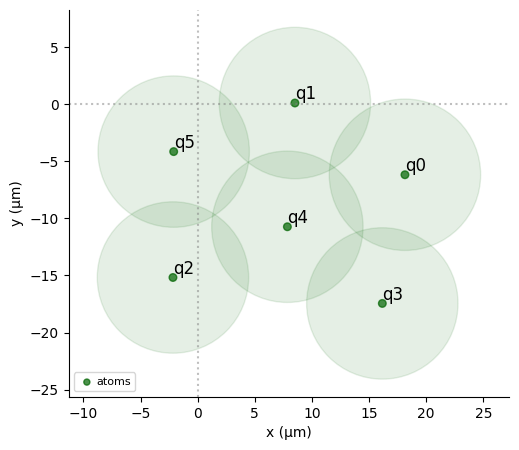

In [91]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [92]:
Q_new

array([[0.        , 2.34559645, 0.04514518, 2.4211346 , 2.66809172,
        0.07642994],
       [2.34559645, 0.        , 0.12936179, 0.11021182, 3.31534694,
        2.42578787],
       [0.04514518, 0.12936179, 0.        , 0.13661079, 3.13218062,
        3.02594381],
       [2.4211346 , 0.11021182, 0.13661079, 0.        , 3.64631107,
        0.04081328],
       [2.66809172, 3.31534694, 3.13218062, 3.64631107, 0.        ,
        1.87998682],
       [0.07642994, 2.42578787, 3.02594381, 0.04081328, 1.87998682,
        0.        ]])

In [94]:
# We choose a median value between the min and the max
# Omega = np.median(Q[Q > 0].flatten())
# Omega = np.median(Q[Q > 1e-3].flatten())
Omega = 2.
delta_0 = -4.  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 10_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

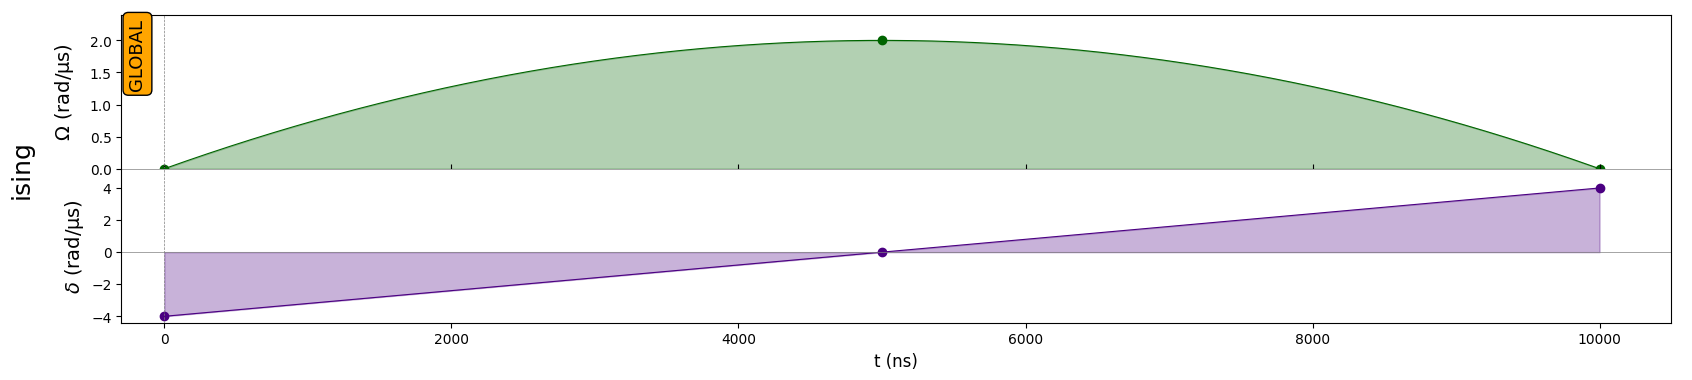

In [95]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [96]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [98]:
sols

['011100', '100011', '000111']

In [99]:
def plot_distribution(C, sols=[]):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in sols else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

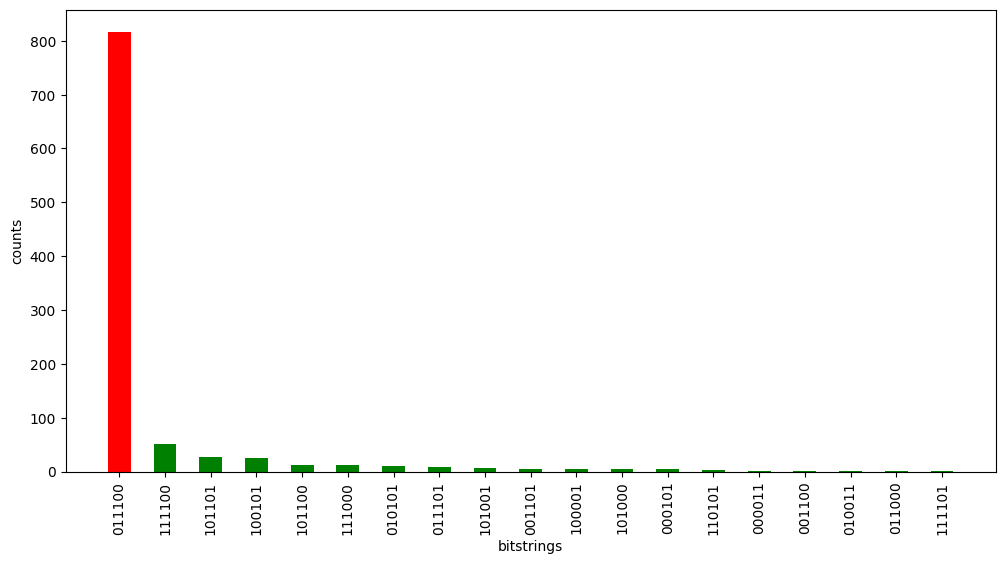

In [100]:
plot_distribution(count_dict, sols)

In [101]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

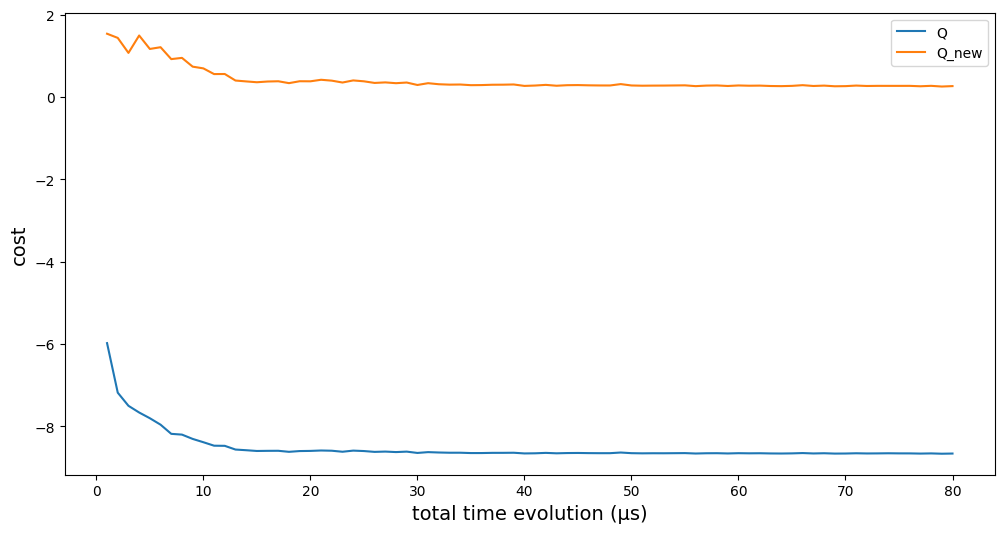

In [103]:
cost_Q = []
cost_newQ = []
nn = 1 # takes very long, can also set to 1
t_end = 80
correct_counts = []
for T in 1000 * np.linspace(1, t_end, t_end*nn):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost_newQ.append(get_cost(count_dict, Q_new) / 3)
    cost_Q.append(get_cost(count_dict, Q) / 3)
    correct_counts.append([count_dict.get(s, 0) / sum(count_dict.values()) for s in sols])

correct_counts = np.array(correct_counts)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cost_Q)+1), np.array(cost_Q), label="Q")
plt.plot(range(1, len(cost_newQ)+1), np.array(cost_newQ), label="Q_new")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.legend()
plt.show()

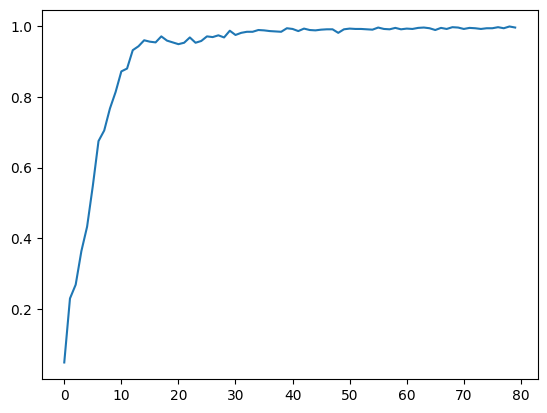

In [105]:
plt.plot(correct_counts[:, 0] + correct_counts[:, 1])